In [29]:
import random
import networkx as nx
import torch
import torch.nn as nn

from deep_ebm.utils_ebm import show_graph, evaluate_model
from deep_ebm.utils_ebm import save_graph, compare_graphs, show_graph_grid, compare_statistics
from deep_ebm.gnn_ebm import GraphDataset, GNN_EBM, train_one_epoch_pcd, gibbs_ministeps

from src.torch_erg import load_pglib_opf as lp
from src.torch_erg.samplers import GWGSampler, MHSampler, GWG_Hybrid_Sampler
from src.torch_erg.utils import laplacian_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle as pkl
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

from Plots_and_utils.plots import *
from Plots_and_utils.other_g_stats import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [16]:
with open("data/30IEEE_synth_dataset/reduced_30IEEE_synth_list_GraphDataset.pkl", "rb") as f:
    dataset_30IEEE  = pkl.load(f)

In [11]:
name = '30_ieee'

# soft connectivity constraint flag, if false then hard constraint is used
SOFT_CONN = True

ordmat, ordlist, buslist, countlist = lp.pow_parser(name)

ordmat = torch.tensor(ordmat)
ordlist = torch.tensor(ordlist)
buslist = torch.tensor(buslist)
countlist = torch.tensor(countlist)

G_sparse = ordmat.cpu().numpy()  # Create sparse matrix
n_components = connected_components(csr_matrix(G_sparse))
print("Number of connected components in the graph:", n_components[0])

class MySampler(GWG_Hybrid_Sampler):
    def __init__(self, backend: str, model: nn.Module):
        super().__init__(backend, model)
    def observables(self, mtx):
        edges = torch.sum(mtx)/2
        triangles = torch.trace(torch.matmul(torch.matmul(mtx,mtx),mtx))/6
        #ac = torch.linalg.eigvalsh(laplacian_matrix(mtx))[1]
        return(torch.stack([edges, triangles]))
        
betas = torch.tensor([0., 0.], dtype=float)


Number of connected components in the graph: 1


In [12]:
#we freeze the node features as we do not need them, so that we can evaluate the model only on the adj matrix
class feat_encoded_model(nn.Module):
    def __init__(self, model, feats):
        super().__init__()
        self.model = model
        self.feats = feats.to(device)

    def forward(self,adj):
        return(self.model(self.feats, adj))

In [13]:
with open("Saved_models/30IEEE_GNN_EBM_30epochs.pkl", "rb") as f:
    Gmodel = pkl.load(f)

In [17]:
A, feats = dataset_30IEEE[0]

In [53]:
adj_model = feat_encoded_model(Gmodel, feats)

sampler = MySampler(backend="cuda",model = adj_model)
obs = sampler.observables(ordmat)
print("observed observables: ", obs)
ordmat = ordmat.to(device)
params, _ = sampler.param_run(graph=ordmat,
                      observables=obs,
                      params=betas,
                      niter=100000,
                      params_update_every=3,
                      save_every=50,
                      save_params=True,
                      alpha=0.05,                      
                      min_change = 0.005)

CUDA backend not available falling back to cpu
observed observables:  tensor([41.,  6.], dtype=torch.float64)


100%|██████████| 100000/100000 [07:07<00:00, 233.69it/s]

number of accepted steps is:  453
number of rejected samples:  99547
number of effective updates is:  151


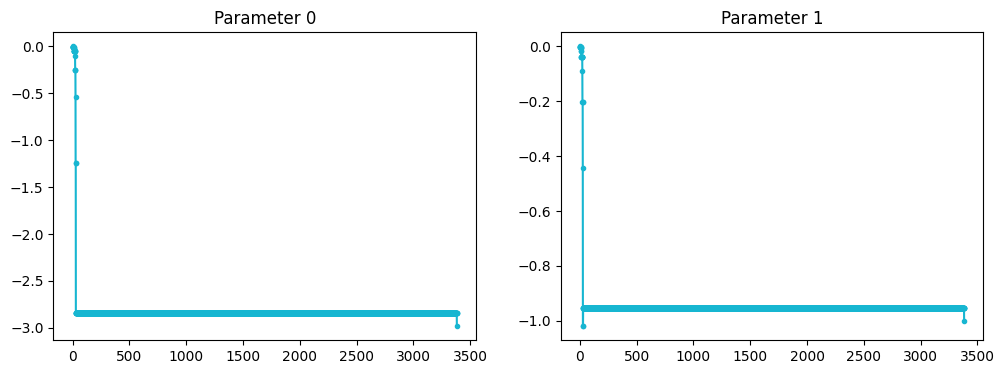

In [54]:
plot_params_iterations(params)

In [72]:
params_for_estimates

tensor([-2.8431, -0.9550], dtype=torch.float64)

In [71]:
obs

tensor([41.,  6.], dtype=torch.float64)

In [56]:
params_for_estimates = torch.stack(params[-100:]).mean(axis = 0)
# run in sample mode, without parameter modifications
observables, graphs = sampler.sample_run(graph=ordmat,
                      observables=obs,
                      params=params_for_estimates,
                      niter=100000,
                      save_every=10,
                      burn_in=0.2)

100%|██████████| 100000/100000 [06:31<00:00, 255.25it/s]

number of accepted steps is:  888
number of rejected samples:  99112
Mean obs:  tensor([52.7146, 10.9994], dtype=torch.float64)


In [70]:
connected_graphs(sampler, graphs, 1), len(graphs)

(([], []), 6594)

In [57]:
observables2, graphs2 = sampler.sample_run(graph=ordmat,
                      observables=torch.tensor([41.,  20.], dtype=torch.float64),
                      params=params_for_estimates,
                      niter=100000,
                      save_every=10,
                      burn_in=0.2)

100%|██████████| 100000/100000 [06:46<00:00, 245.87it/s]

number of accepted steps is:  352
number of rejected samples:  99648
Mean obs:  tensor([52.8032, 34.6774], dtype=torch.float64)


In [69]:
connected_graphs(sampler, graphs2, 1), len(graphs2)

(([], []), 9013)

In [58]:
observables3, graphs3 = sampler.sample_run(graph=ordmat,
                      observables=torch.tensor([30,  20.], dtype=torch.float64),
                      params=params_for_estimates,
                      niter=100000,
                      save_every=10,
                      burn_in=0.2)

100%|██████████| 100000/100000 [05:34<00:00, 298.56it/s]

number of accepted steps is:  1144
number of rejected samples:  98856
Mean obs:  tensor([49.9912, 18.7644], dtype=torch.float64)


In [68]:
connected_graphs(sampler, graphs3, 1), len(graphs3)

(([], []), 8497)

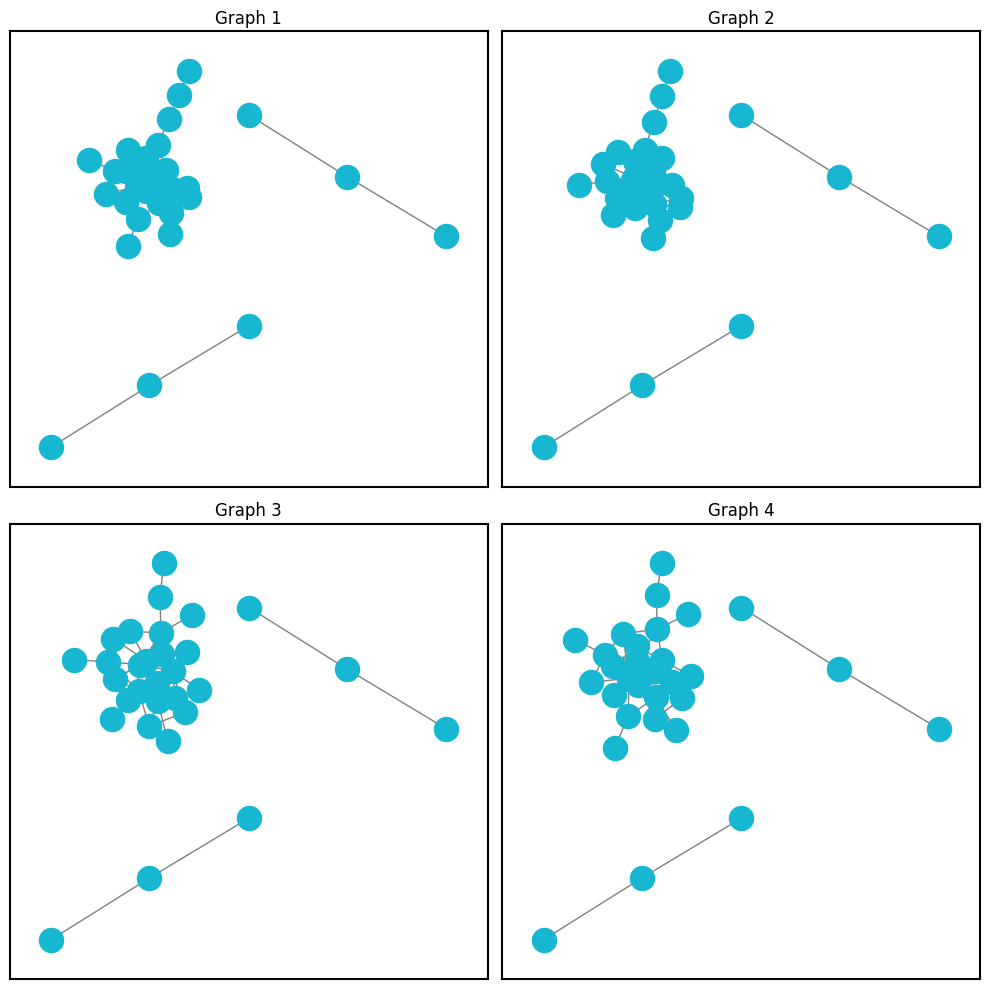

In [74]:
plot_random_graphs(graphs, 4)